In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat
from read_cats import GetSDSSCat

from utils import *

In [2]:
zbins = [(1.0, 5.0)]#, (1.,2.15), (2.15,2.50),(2.50,5.0)]
# zbins = [(0.1, 5.), (1.0, 5.0), (1.,2.15), (2.15,2.50),(2.50,5.0)]


# PACS channels
lambdas = [100, 160]#250, 350, 500]

# Cutouts (half-)size in pixels
npix    = {100:49, # PACS pixels are ~ 3  arcsec -> cutouts are 5'
           160:37,  # PACS pixels are ~ 4  arcsec -> cutouts are 5'
           250:25,  # SPIRE pixels are ~ 6  arcsec -> cutouts are 5'
           350:19,  # SPIRE pixels are ~ 8  arcsec -> cutouts are 5'
           500:13}  # SPIRE pixels are ~ 12 arcsec -> cutouts are 5'

# Beam @ different freq
psf     = {100:11.4, # in arcsec
           160:13.7, # in arcsec
           250:17.8, # in arcsec
           350:24.0, # in arcsec
           500:35.2} # in arcsec

factor  = {100:1., 		   # Jy/pixel
           160:1,  		   # Jy/pixel
           250:469./36.,   # Jy/beam -> Jy/pixel
           350:831./64.,   # Jy/beam -> Jy/pixel
           500:1804./144.} # Jy/beam -> Jy/pixel

# Pixel resolution
reso    = {100:3.,  # in arcsec
           160:4.,  # in arcsec
           250:6.,  # in arcsec
           350:8.,  # in arcsec
           500:12.} # in arcsec

positions = {100: (49.5,49.5),
             160: (37.5,37.5),
             250: (25.5,25.5), 
             350: (19.5,19.5), 
             500: (13.5,13.5)}

# boxsize = {250:51, 350:39, 500:27}
# boxsize    = {250:101, 350:77, 500:51} # SPIRE pixels are ~ 6/8/12 arcsec -> cutouts are 5'
# positions = {250: (101/2., 101/2.), 350: (77/2.,77/2.), 500:(51/2.,51/2.)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# QSO features to be included
extras_names = [
    'RA',
    'DEC',
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w2 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w3 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w4 magnitude WISE
    'CC_FLAGS',       # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies]
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


In [4]:
anal = CutoutAnalysis('results_PACS_H-ATLAS/', zbins=zbins, extras_names=extras_names, lambdas=lambdas)


In [5]:
anal_spire = CutoutAnalysis('results_filt_H-ATLAS/', zbins=zbins, extras_names=extras_names, lambdas=[250,350,500])

IOError: [Errno 2] No such file or directory: 'results_filt_H-ATLAS//patchG9_lambda250_zmin1.0_zmax5.0.pkl'

In [6]:
print anal.GetTotPhotometryFromStacks(100,0,8, remove_max=10)
print anal.GetTotPhotometryFromStacks(160,0,8)


2.32443970721
2.57122123684


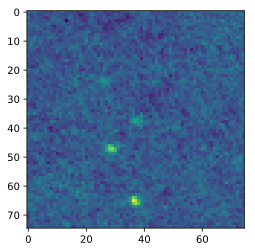

In [68]:
plt.imshow(anal.cuts[160]['G12'][0].mean(0), interpolation=None)


In [47]:
anal.cuts[100]['G15'][0].mean(0).shape

(99, 99)

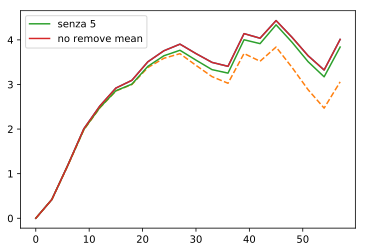

In [140]:
plt.plot(reso[100]*np.arange(20), [anal.GetPhotometryFromStacks(100, 'G9',  0, r, r_in=20, r_out=20*np.sqrt(2),  remove_max=0) for r in np.arange(20)],)
plt.plot(reso[100]*np.arange(20), [anal.GetPhotometryFromStacks(100, 'G9',  0, r,  remove_max=0) for r in np.arange(20)], '--')
plt.plot(reso[100]*np.arange(20), [anal.GetPhotometryFromStacks(100, 'G9',  0, r, r_in=20, r_out=20*np.sqrt(2), remove_max=5) for r in np.arange(20)],label='senza 5')
plt.plot(reso[100]*np.arange(20), [anal.GetPhotometryFromStacks(100, 'G9',  0, r, r_in=20, r_out=20*np.sqrt(2), remove_mean=0) for r in np.arange(20)],label='no remove mean')
plt.legend()

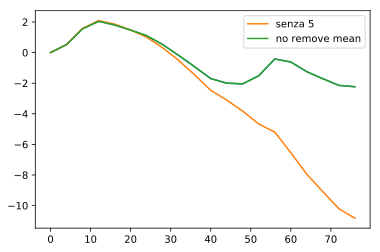

In [141]:
plt.plot(reso[160]*np.arange(20), [anal.GetPhotometryFromStacks(160, 'G12',  0, r, remove_max=0) for r in np.arange(20)],)
plt.plot(reso[160]*np.arange(20), [anal.GetPhotometryFromStacks(160, 'G12',  0, r, remove_max=20) for r in np.arange(20)],label='senza 5')
plt.plot(reso[160]*np.arange(20), [anal.GetPhotometryFromStacks(160, 'G12',  0, r, remove_mean=0) for r in np.arange(20)],label='no remove mean')
plt.legend()

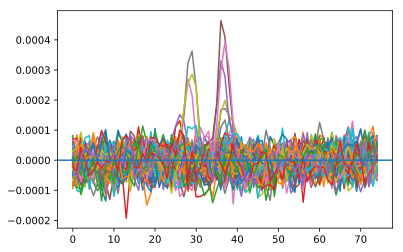

In [71]:
for i in xrange(anal.cuts[160]['G12'][0].mean(0).shape[0]):
    plt.plot(anal.cuts[160]['G12'][0].mean(0)[i,:])
plt.axhline()

In [66]:
reso

{100: 3.0, 160: 4.0, 250: 6.0, 350: 8.0, 500: 12.0}

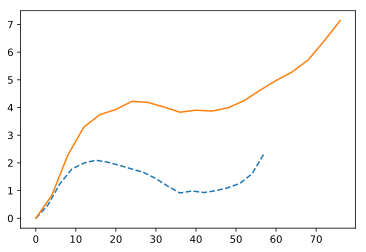

In [147]:
plt.plot(reso[100]*np.arange(20), [anal.GetTotPhotometryFromStacks(100,  0, r, r_in=35/reso[100], r_out=45/reso[100], remove_max=0) for r in np.arange(20)], '--')
plt.plot(reso[160]*np.arange(20), [anal.GetTotPhotometryFromStacks(160,  0, r, r_in=35/reso[160], r_out=45/reso[160], remove_max=0) for r in np.arange(20)],)


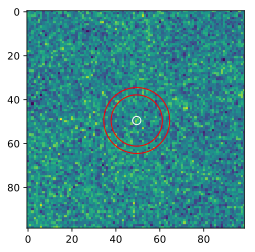

In [16]:
l = 100
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.mean(np.concatenate([anal.cuts[l][p][2] for p in patches]),axis=0))
circin = plt.Circle(positions[l], radius=5.6/reso[l], color='w', fill=False)
# circout = plt.Circle(positions[l], radius=2*psf[l]/reso[l], color='r', fill=False)
circout2 = plt.Circle(positions[l], radius=35/reso[l], color='r', fill=False)
circout3 = plt.Circle(positions[l], radius=45/reso[l], color='r', fill=False)
ax.add_patch(circin)
# ax.add_patch(circout)
ax.add_patch(circout2)
ax.add_patch(circout3)


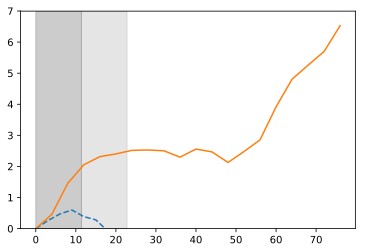

In [148]:
plt.plot(reso[100]*np.arange(20), [anal.GetTotPhotometryFromStacks(100,  2, r, remove_max=0, r_in=35/reso[100], r_out=45/reso[100]) for r in np.arange(20)],'--')
plt.plot(reso[160]*np.arange(20), [anal.GetTotPhotometryFromStacks(160,  2, r, remove_max=0, r_in=35/reso[160], r_out=45/reso[160]) for r in np.arange(20)],label='senza 5')
plt.ylim(0)
plt.axvspan(0, psf[100], alpha=0.4, color='grey', label=r'Beam')
plt.axvspan(psf[100], 2*psf[100], alpha=0.2, color='grey')


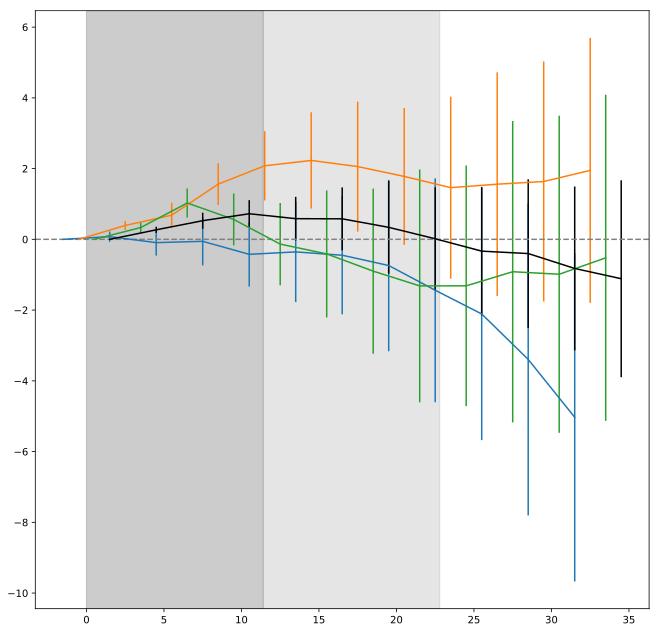

In [143]:
rmax = 12
nsim = 100

lambda_ = 100
idz = 2
i = 1 
plt.figure(figsize=(11,11))
# for idz, zbin in enumerate(zbins):
#     for lambda_ in lambdas:
#         plt.subplot(3,3,i)
# plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))

err9   = [anal.GetBootstrapErrs(lambda_, 'G9',  idz, r, remove_max=1, nsim=nsim) for r in np.arange(rmax)]
err12  = [anal.GetBootstrapErrs(lambda_, 'G12', idz, r, remove_max=1, nsim=nsim) for r in np.arange(rmax)]
err15  = [anal.GetBootstrapErrs(lambda_, 'G15', idz, r, remove_max=1, nsim=nsim) for r in np.arange(rmax)]
errTot = [anal.GetTotBootstrapErrs(lambda_, idz, r, remove_max=1, nsim=nsim) for r in np.arange(rmax)]

plt.errorbar(reso[lambda_]*np.arange(rmax)-1.5, [anal.GetPhotometryFromStacks(lambda_, 'G9',  idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err9, label='G9')
plt.errorbar(reso[lambda_]*np.arange(rmax)-0.5, [anal.GetPhotometryFromStacks(lambda_, 'G12', idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err12, label='G12')
plt.errorbar(reso[lambda_]*np.arange(rmax)+0.5, [anal.GetPhotometryFromStacks(lambda_, 'G15', idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err15, label='G15')
plt.errorbar(reso[lambda_]*np.arange(rmax)+1.5, [anal.GetTotPhotometryFromStacks(lambda_, idz, r, remove_max=1) for r in np.arange(rmax)], yerr=errTot, label='Tot', color='k')

plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
plt.axhline(ls='--', color='grey')

In [24]:
anal_spire.GetTotPhotometryFromStacks(250, 0, 224)

10.494055172128128

In [22]:
anal_spire.GaussFitTot(250, 0).amplitude.value

5.014921470584917

## Complete analysis

In [3]:
anal_all = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE/', zbins=zbins, extras_names=extras_names, lambdas=[100,160,250,350,500])


In [4]:
qso_cat = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins)

	...z-bin : 1.0 < z < 5.0


In [7]:
giulio_fluxes = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_stacked_fluxes_soergel_allPointSourcesmask_allsrc.dat')

In [8]:
giulio_fluxes_corr = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_GNILC_CIB_stacked_fluxes_soergel_allPointSourcesmask_allsrc.dat')

In [5]:
planck = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,5], giulio_fluxes[:-1,10]]

In [6]:
planck

array([[  1.00000000e+04,  -2.55192000e-01,   1.74887000e-01],
       [  6.81818000e+03,  -5.90412000e-01,   3.02953000e-01],
       [  4.28571000e+03,   5.81893000e-02,   2.28779000e-01],
       [  3.00000000e+03,   1.69888000e-01,   1.37433000e-01],
       [  2.09790000e+03,   2.25661000e-01,   8.15567000e-02],
       [  1.38249000e+03,   9.77750000e-01,   7.04593000e-02],
       [  8.49858000e+02,   4.59420000e+00,   1.32140000e-01],
       [  5.50459000e+02,   1.07549000e+01,   2.25118000e-01],
       [  3.50058000e+02,   1.18087000e+01,   3.02727000e-01]])

In [7]:
planck[6:,1] - planck_corr[:,1]

NameError: name 'planck_corr' is not defined

In [ ]:
PLANCK = planck.copy()
PLANCK[6:,1] -= planck_corr[:,1]
PLANCK[6:,2] = np.sqrt(PLANCK[6:,2]**2 + planck_corr[:,2]**2)

In [59]:
planck_corr = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,5], giulio_fluxes_corr[:,10]]

In [8]:
akari = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,5], giulio_fluxes[-1,10]]

In [68]:
qso_cat.WriteToFileFromAnal(0, herschel=anal_all, planck=PLANCK, akari=akari, filename='SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub')

100 0.930541622058
160 2.56260585071
250 4.66675891218
350 4.43672061929
500 3.26328216745


100 0.930541622058 0.115337097502
160 2.56260585071 0.231915732822
250 4.66675891218 0.220150437931
350 4.43672061929 0.152219631868
500 3.26328216745 0.161209419956


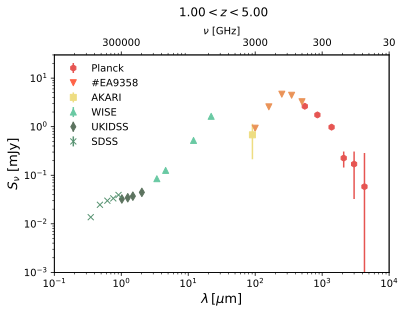

In [102]:
qso_cat.PlotFromAnal(0, planck=PLANCK, akari=akari, herschel=anal_all)
# plt.grid()
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_1_z_5_wPACS_wAKARI_wPlanck_CIBcorr_mean.pdf', bboxes_inches='tight')

In [78]:
qso_cat.erru_mean

{0: 5.4084657306363811e-05, 'all': 5.408465730636396e-05}

100 0.930541622058 0.109115396371
160 2.56260585071 0.246238990141
250 4.66675891218 0.224348926177
350 4.43672061929 0.153050250359
500 3.26328216745 0.138743580465


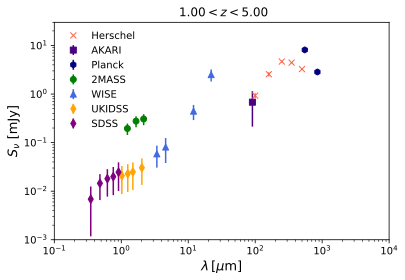

In [32]:
qso_cat.PlotFromAnal(0, herschel=anal_all, planck=np.c_[giulio_fluxes_corr[:-1,0], giulio_fluxes_corr[:-1,5], giulio_fluxes_corr[:-1,10]], akari=akari)


100 0.930541622058 0.106263552151
160 2.56260585071 0.216732401567
250 4.66675891218 0.221110849981
350 4.43672061929 0.146789685648
500 3.26328216745 0.157337604366


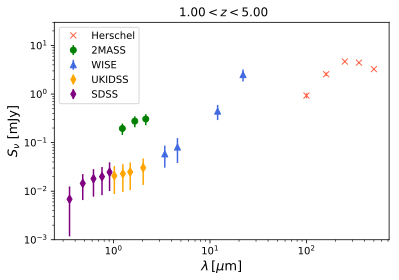

In [81]:
qso_cat.PlotFromAnal(1, anal=anal_all)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_1_z_5_wPACS.pdf', bboxes_inches='tight')

In [73]:
a = qso_cat.cat[0][(qso_cat.cat[0].CC_FLAGS=='0000') & (qso_cat.cat[0].W4SNR>=2)]

In [107]:
qso_cat.GetFluxesCats('WISE')

In [111]:
qso_cat.errw3_limits[0], qso_cat.errw3[0]

([(-0.0027420551448468222, 0.15494413896714643)],
 [(0.16071710879540796, 0.41256015565986826)])

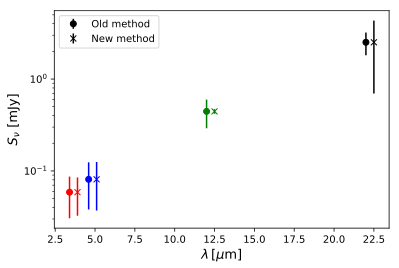

In [131]:
idz = 1
plt.errorbar(3.4, qso_cat.medw1[idz], qso_cat.errw1[idz], color='r', fmt='o')
plt.errorbar(3.4+0.5, qso_cat.medw1[idz], qso_cat.errw1_limits[idz], color='r', fmt='x')
plt.errorbar(4.6, qso_cat.medw2[idz], qso_cat.errw2[idz], color='b', fmt='o')
plt.errorbar(4.6+0.5, qso_cat.medw2[idz], qso_cat.errw2_limits[idz], color='b', fmt='x')
plt.errorbar(12, qso_cat.medw3[idz], qso_cat.errw3[idz], color='g', fmt='o')
plt.errorbar(12+0.5, qso_cat.medw3[idz], qso_cat.errw3_limits[idz], color='g', fmt='x')
plt.errorbar(22, qso_cat.medw4[idz], qso_cat.errw4[idz], color='k', fmt='o', label='Old method')
plt.errorbar(22+0.5, qso_cat.medw4[idz], qso_cat.errw4_limits[idz], color='k', fmt='x', label='New method')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\lambda\,[\mu$m]', size=13)
plt.ylabel(r'$S_{\nu}$ [mJy]', size=13)
plt.savefig('/Users/fbianchini/Research/StacktSZ/test_WISE_W4_limits.pdf', bboxes_inches='tight')

In [119]:
qso_cat.cat[1][(qso_cat.cat[1].CC_FLAGS=='0000')].W4MAG.min()

4.7649999999999997

In [121]:
qso_cat.medw3[1]

0.44453188014905304

In [124]:
qso_cat.low3_limits[1], qso_cat.hiw3_limits[1]

(0.41847086628855246, 0.58092430851126631)

In [125]:
qso_cat.low3[1], qso_cat.hiw3[1]

(0.29127479976965082, 0.81264882618282452)

In [ ]:
plt.imshow(anal.bkd[100]['G9'][0].mean(0))

## $dN/dz$ plot for the paper

In [3]:
qso_cat_all = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,10.)])
qso_cat_DR12 = QSOcat(GetSDSSCat(cats=['DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,10.)])
qso_cat_DR7 = QSOcat(GetSDSSCat(cats=['DR7'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,10.)])

	...z-bin : 0.0 < z < 10.0
	...z-bin : 0.0 < z < 10.0
	...z-bin : 0.0 < z < 10.0


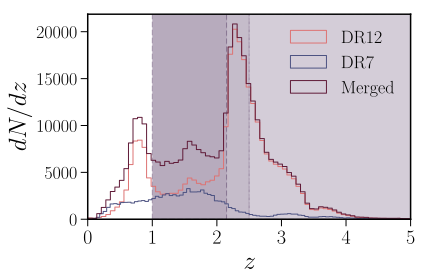

In [44]:
# plt.axvline(1, ls='--',)# color='royalblue')
# plt.axvline(2.15, ls='--',)# color='royalblue')
# plt.axvline(2.5, ls='--',)# color='royalblue')

plt.axvspan(1, 2.15, color='#70587C', alpha=0.5, ls='--')
plt.axvspan(2.15, 2.5, color='#70587C', alpha=0.4, ls='--')
plt.axvspan(2.5, 5.0, color='#70587C', alpha=0.3, ls='--')

hist(qso_cat_DR12.cat[0].Z, bins=100, histtype='step', color='#DD7373', label='DR12')#, normed=1)
hist(qso_cat_DR7.cat[0].Z, bins=100, histtype='step', color='#4D5382', label='DR7')#, normed=1)
hist(qso_cat_all.cat[0].Z, bins=100, histtype='step', color='#5F1A37', label='Merged')#, normed=1)

# hist(anal.extras[100]['G9'][0]['Z'], 'knuth', histtype='stepfilled', color='lightgrey', normed=1)
plt.xlim([0,5])
plt.xlabel(r'$z$')#, size=15)
plt.ylabel(r'$dN/dz$')#, size=15)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/StacktSZ/dNdz_QSO2.pdf')#, bboxes_inches='tight')

In [43]:
from matplotlib import rc, rcParams

import seaborn as sns
   
sns.set(rc('font',**{'family':'serif','serif':['Computer Modern']}))
sns.set_style("ticks", {'figure.facecolor': 'grey'})

rc('text',usetex=True)
# rc('font',**{'family':'serif','serif':['Computer Modern']})
plt.rcParams['axes.linewidth']  = 1.5
plt.rcParams['axes.labelsize']  = 25
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['legend.fontsize']  = 18
plt.rcParams['legend.frameon']  = False

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [25]:
len(np.concatenate([anal.extras[160][p][1]['Z'] for p in patches]))

7115

In [24]:
anal.zbins

[(0.1, 5.0), (1.0, 5.0), (1.0, 2.15), (2.15, 2.5), (2.5, 5.0)]

## Cataloghi per $z<1$ per Joaquin

In [2]:
qso_cat_z1_wfirst = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=False, z_DR12='Z_PIPE'), [(0.,1.)])

	...z-bin : 0.0 < z < 1.0


In [3]:
qso_cat_z1_wofirst = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(0.,1.)])

	...z-bin : 0.0 < z < 1.0


In [11]:
print len(qso_cat_z1_wofirst.cat[0])
print len(qso_cat_z1_wfirst.cat[0])
print len(qso_cat_z1_wofirst.cat[0])*1./len(qso_cat_z1_wfirst.cat[0])

68582
72718
0.94312274815


In [24]:
np.savetxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_DR7_DR12_wFIRST.dat', 
          np.c_[qso_cat_z1_wfirst.cat[0].RA, qso_cat_z1_wfirst.cat[0].DEC, qso_cat_z1_wfirst.cat[0].Z],
         header='''QSO from merged SDSS DR7 & DR12 catalogs\n This contains objects w/ FIRST counterpart  \n  RA   DEC   Z''')

In [22]:
np.savetxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSO_DR7_DR12_woFIRST.dat', 
          np.c_[qso_cat_z1_wofirst.cat[0].RA, qso_cat_z1_wofirst.cat[0].DEC, qso_cat_z1_wofirst.cat[0].Z],
         header='''QSO from merged SDSS DR7 & DR12 catalogs\n This DOESN'T contain objects w/ FIRST counterpart \n RA   DEC   Z''')

In [25]:
qso_cat_z1_DR7 = QSOcat(GetSDSSCat(cats=['DR7'], discard_FIRST=False, z_DR12='Z_PIPE'), [(0.,1.)])

	...z-bin : 0.0 < z < 1.0


In [26]:
qso_cat_z1_DR12 = QSOcat(GetSDSSCat(cats=['DR12'], discard_FIRST=False, z_DR12='Z_PIPE'), [(0.,1.)])

	...z-bin : 0.0 < z < 1.0


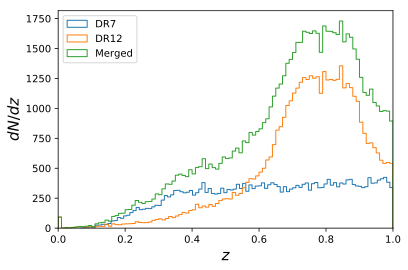

In [36]:
hist(qso_cat_z1_DR7.cat[0].Z, 100, label='DR7', histtype='step')
hist(qso_cat_z1_DR12.cat[0].Z, 100, label='DR12', histtype='step')
hist(qso_cat_z1_wfirst.cat[0].Z, 100, label='Merged', histtype='step')
# hist(qso_cat_z1_wofirst.cat[0].Z, 100, label='Merged w/o FIRST', histtype='step')
plt.xlabel(r'$z$',size=15)
plt.ylabel(r'$dN/dz$',size=15)
plt.xlim(0.,1)
plt.legend(loc='upper left')
plt.savefig('/Users/fbianchini/Research/StacktSZ/QSO_SDSS_DR7_DR12_zless1.pdf')

## Survival analysis & Kaplan-Meier

In [3]:
qso = QSOcat(GetSDSSCat(discard_FIRST=True, z_DR12='Z_PIPE'), [(1.,5.)])

	...z-bin : 1.0 < z < 5.0


In [4]:
from lifelines.datasets import load_lcd
from lifelines import KaplanMeierFitter

kmf_W4 = KaplanMeierFitter()
kmf_W3 = KaplanMeierFitter()
kmf_W1 = KaplanMeierFitter()
kmf_W2 = KaplanMeierFitter()


In [5]:
myqso_W4 = qso.cat[0][(~np.isnan(qso.cat[0].W4MAG)) & (qso.cat[0].CC_FLAGS == '0000')]
detected_W4 = myqso_W4.W4SNR >= 2
fluxes_W4 = WISEMag2mJy(myqso_W4.W4MAG, 'W4')

In [6]:
myqso_W3 = qso.cat[0][(~np.isnan(qso.cat[0].W3MAG)) & (qso.cat[0].CC_FLAGS == '0000')]
detected_W3 = myqso_W3.W3SNR >= 2
fluxes_W3 = WISEMag2mJy(myqso_W3.W3MAG, 'W3')

In [7]:
myqso_W2 = qso.cat[0][(~np.isnan(qso.cat[0].W2MAG)) & (qso.cat[0].CC_FLAGS == '0000')]
detected_W2 = myqso_W2.W2SNR >= 2
fluxes_W2 = WISEMag2mJy(myqso_W2.W2MAG, 'W2')

In [8]:
myqso_W1 = qso.cat[0][(~np.isnan(qso.cat[0].W1MAG)) & (qso.cat[0].CC_FLAGS == '0000')]
detected_W1 = myqso_W1.W1SNR >= 2
fluxes_W1 = WISEMag2mJy(myqso_W1.W1MAG, 'W1')

In [12]:
kmf_W3.fit(fluxes_W3, event_observed=detected_W3, left_censorship=True)
kmf_W4.fit(fluxes_W4, event_observed=detected_W4, left_censorship=True)
kmf_W2.fit(fluxes_W2, event_observed=detected_W2, left_censorship=True)
kmf_W1.fit(fluxes_W1, event_observed=detected_W1, left_censorship=True)


<lifelines.KaplanMeierFitter: fitted with 139471 observations, 122 censored>

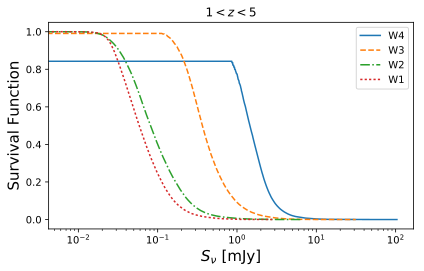

In [16]:
plt.plot(kmf_W4.timeline, 1.-kmf_W4.cumulative_density_, label='W4')
plt.plot(kmf_W3.timeline, 1.-kmf_W3.cumulative_density_, '--', label='W3')
plt.plot(kmf_W2.timeline, 1.-kmf_W2.cumulative_density_, '-.', label='W2')
plt.plot(kmf_W1.timeline, 1.-kmf_W1.cumulative_density_, ':',  label='W1')
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]', size=15)
plt.ylabel(r'Survival Function', size=15)
# plt.xlim(1e-10,10)
plt.xscale('log')
plt.title(r'$1<z<5$')
plt.tight_layout()
# plt.savefig('/Users/fbianchini/Research/StacktSZ/WISE_KaplanMeier_test_1z5_inverse.pdf')

In [18]:
from scipy import integrate, interpolate, optimize


In [19]:
cd_W4 = interpolate.interp1d(kmf_W4.timeline, 1.-kmf_W4.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
f_W4 = lambda x : integrate.romberg(cd_W4, kmf_W4.timeline.min(), x) - integrate.quad(cd_W4, 0, np.inf)[0]/2.#0.5

cd_W3 = interpolate.interp1d(kmf_W3.timeline, 1.-kmf_W3.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
f_W3 = lambda x : integrate.romberg(cd_W3, kmf_W3.timeline.min(), x) - integrate.quad(cd_W3, 0, np.inf)[0]/2.#0.5

cd_W2 = interpolate.interp1d(kmf_W2.timeline, 1.-kmf_W2.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
f_W2 = lambda x : integrate.romberg(cd_W2, kmf_W2.timeline.min(), x) - integrate.quad(cd_W2, 0, np.inf)[0]/2.#0.5

cd_W1 = interpolate.interp1d(kmf_W1.timeline, 1.-kmf_W1.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
f_W1 = lambda x : integrate.romberg(cd_W1, kmf_W1.timeline.min(), x) - integrate.quad(cd_W1, 0, np.inf)[0]/2.#0.5

In [20]:
print 'W4:',integrate.quad(cd_W4, 0, np.inf)
print 'W3:',integrate.quad(cd_W3, 0, np.inf)
print 'W2:',integrate.quad(cd_W2, 0, np.inf)
print 'W1:',integrate.quad(cd_W1, 0, np.inf)

W4: (1.6336448729734108, 0.0006540123971510159)
W3: (0.5208036348659502, 0.00015134191028598476)
W2: (0.12570727800741255, 1.327865353389912e-05)
W1: (0.08480048560818791, 2.558974348207399e-05)


/Users/fbianchini/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [564]:
print 'W4:',optimize.brentq(f_W4, 0, 20)#kmf_W4.timeline.min(),kmf_W4.timeline.max())
print 'W3:',optimize.brentq(f_W3, 0, 20)#kmf_W3.timeline.min(),kmf_W3.timeline.max())
print 'W2:',optimize.brentq(f_W2, 0, 20)#kmf_W1.timeline.min(),kmf_W1.timeline.max())
print 'W1:',optimize.brentq(f_W1, 0, 20)#kmf_W1.timeline.min(),kmf_W1.timeline.max())


W4: 0.973464986769
W3: 0.285546925669
W2: 0.0763847813515
W1: 0.0477948327089


In [10]:
print 'W4:', ((1.-kmf_W4.cumulative_density_) >= 0.5).idxmin(0)
print 'W3:', ((1.-kmf_W3.cumulative_density_) >= 0.5).idxmin(0)
print 'W2:', ((1.-kmf_W2.cumulative_density_) >= 0.5).idxmin(0)
print 'W1:', ((1.-kmf_W1.cumulative_density_) >= 0.5).idxmin(0)


W4: KM_estimate    1.453323
dtype: float64
W3: KM_estimate    0.366018
dtype: float64
W2: KM_estimate    0.08102
dtype: float64
W1: KM_estimate    0.058603
dtype: float64


In [446]:
detected_W4_ = myqso_W4.W4SNR >= 2
detected_W4_ = detected_W4_[:2000]
fluxes_W4_ = myqso_W4.W4MAG[:2000]

In [447]:
kmf_ = KaplanMeierFitter()

In [448]:
kmf_.fit(WISEMag2mJy(fluxes_W4_,'W4'), event_observed=detected_W4_, left_censorship=True)

<lifelines.KaplanMeierFitter: fitted with 2000 observations, 1659 censored>

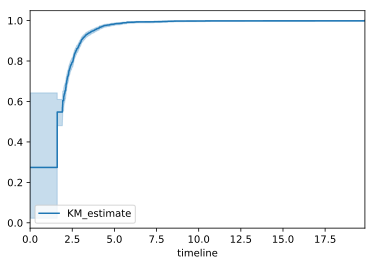

In [449]:
kmf_.plot()

In [228]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
kmf = KaplanMeierFitter()

def BoostrapKM(df, channel, nsim=100, nboot=2):
    flux = np.zeros(nsim)

    for i in xrange(nsim):
        ids = np.random.choice(np.arange(len(df)), size=len(df)/nboot)
        df_ = df.iloc[ids]
#         detected = df_.W4SNR >= 2
#         fluxes = WISEMag2mJy(df_.W4MAG,'W4')
        detected = df_[channel+'SNR'] >= 2
        fluxes = WISEMag2mJy(df_[channel+'MAG'], channel)
        
        kmf.fit(fluxes, event_observed=detected, left_censorship=True)

        cd = interpolate.interp1d(kmf.timeline, 1.-kmf.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
        flux[i] = integrate.quad(cd, 0, np.inf)[0]
#         flux[i] = ((1.-kmf.cumulative_density_) >= 0.5).idxmin(0)

    return flux
#     return np.percentile(flux, 16), np.percentile(flux, 84)


In [27]:
min_W4, max_W4 = BoostrapKM(myqso_W4, 'W4')
min_W3, max_W3 = BoostrapKM(myqso_W3, 'W3')
min_W2, max_W2 = BoostrapKM(myqso_W2, 'W2')
min_W1, max_W1 = BoostrapKM(myqso_W1, 'W1')

In [28]:
print min_W4, max_W4
print min_W3, max_W3
print min_W2, max_W2
print min_W1, max_W1

1.44510073372 1.46272302172
0.365008444814 0.367085252412
0.0805731412389 0.0812438125486
0.0583870829566 0.0588188837418


In [50]:
x = BoostrapKM(myqso_W4,'W4', nsim=1000)

0.0151665014661


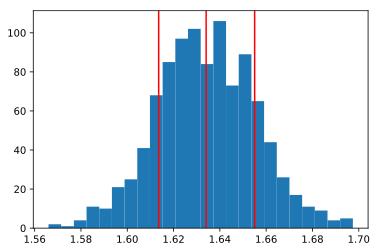

In [51]:
hist(x, 'knuth')
plt.axvline(np.percentile(x, 16),color='r')
plt.axvline(np.percentile(x, 50),color='r')
plt.axvline(np.percentile(x, 84),color='r')
print np.std(x)/np.sqrt(2)

In [21]:
print WISEMag2mJy(myqso_W4.W4MAG,'W4').mean()
print WISEMag2mJy(myqso_W4[myqso_W4.W4SNR>=2].W4MAG,'W4').sum()/len(myqso_W4)

2.7272824451
0.694994025038


In [22]:
print WISEMag2mJy(myqso_W3.W3MAG,'W3').mean()
print WISEMag2mJy(myqso_W3[myqso_W3.W3SNR>=2].W3MAG,'W3').sum()/len(myqso_W3)

0.580924308511
0.418470866289


In [23]:
print WISEMag2mJy(myqso_W2[myqso_W2.W2SNR>=2].W2MAG,'W2').sum()/len(myqso_W2)
print WISEMag2mJy(myqso_W2.W2MAG,'W2').mean()

0.125019846528
0.126020128215


In [24]:
print WISEMag2mJy(myqso_W1.W1MAG,'W1').mean()
print WISEMag2mJy(myqso_W1[myqso_W1.W1SNR>=2].W1MAG,'W3').sum()/len(myqso_W1)

0.0848868153159
0.00867888617732


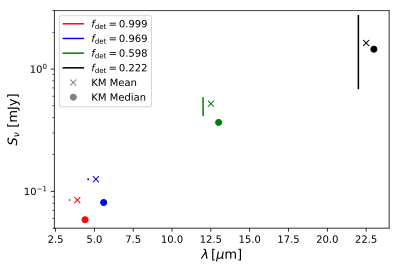

In [38]:
plt.plot((3.4,3.4),  (WISEMag2mJy(myqso_W1[myqso_W1.W1SNR>=2].W1MAG,'W1').sum()/len(myqso_W1), WISEMag2mJy(myqso_W1.W1MAG,'W1').mean()), color='r', label=r'$f_{\rm det}=%.3f$' %(WISEMag2mJy(myqso_W1[myqso_W1.W1SNR>=2].W1MAG,'W1').size*1./WISEMag2mJy(myqso_W1.W1MAG,'W1').size))
plt.plot((4.6, 4.6), (WISEMag2mJy(myqso_W2[myqso_W2.W2SNR>=2].W2MAG,'W2').sum()/len(myqso_W2), WISEMag2mJy(myqso_W2.W2MAG,'W2').mean()), color='b', label=r'$f_{\rm det}=%.3f$' %(WISEMag2mJy(myqso_W2[myqso_W2.W2SNR>=2].W2MAG,'W2').size*1./WISEMag2mJy(myqso_W2.W2MAG,'W2').size))
plt.plot((12, 12),   (WISEMag2mJy(myqso_W3[myqso_W3.W3SNR>=2].W3MAG,'W3').sum()/len(myqso_W3), WISEMag2mJy(myqso_W3.W3MAG,'W3').mean()), color='g', label=r'$f_{\rm det}=%.3f$' %(WISEMag2mJy(myqso_W3[myqso_W3.W3SNR>=2].W3MAG,'W3').size*1./WISEMag2mJy(myqso_W3.W3MAG,'W3').size))
plt.plot((22, 22),   (WISEMag2mJy(myqso_W4[myqso_W4.W4SNR>=2].W4MAG,'W4').sum()/len(myqso_W4), WISEMag2mJy(myqso_W4.W4MAG,'W4').mean()), color='k', label=r'$f_{\rm det}=%.3f$' %(WISEMag2mJy(myqso_W4[myqso_W4.W4SNR>=2].W4MAG,'W4').size*1./WISEMag2mJy(myqso_W4.W4MAG,'W4').size))
# plt.plot((3.4+0.5,3.4+0.5), (min_W1, max_W1), 'r')
# plt.plot((4.6+0.5, 4.6+0.5),(min_W2, max_W2), 'b')
# plt.plot((12+0.5, 12+0.5), (min_W3, max_W3), 'g') 
# plt.plot((22+0.5, 22+0.5), (min_W4, max_W4), 'k') 
plt.plot(3.4+1, ((1.-kmf_W1.cumulative_density_) >= 0.5).idxmin(0), 'ro')
plt.plot(4.6+1, ((1.-kmf_W2.cumulative_density_) >= 0.5).idxmin(0), 'bo')
plt.plot(12+1, ((1.-kmf_W3.cumulative_density_) >= 0.5).idxmin(0), 'go')
plt.plot(22+1, ((1.-kmf_W4.cumulative_density_) >= 0.5).idxmin(0), 'ko')
plt.plot(3.4+0.5,integrate.quad(cd_W1, 0, np.inf)[0], 'rx')
plt.plot(4.6+0.5,integrate.quad(cd_W2, 0, np.inf)[0], 'bx')
plt.plot(12+0.5, integrate.quad(cd_W3, 0, np.inf)[0], 'gx')
plt.plot(22+0.5, integrate.quad(cd_W4, 0, np.inf)[0], 'kx')

plt.plot(10, 100, 'x', color='grey', label='KM Mean')
plt.plot(10, 100, 'o', color='grey', label='KM Median')

plt.ylim(5e-2,3)

plt.legend()
plt.yscale('log')
# plt.legend()
plt.xlabel(r'$\lambda\,[\mu$m]', size=13)
plt.ylabel(r'$S_{\nu}$ [mJy]', size=13)
plt.savefig('/Users/fbianchini/Research/StacktSZ/test_WISE_W4_limits_KM_mean.pdf', bboxes_inches='tight')

In [30]:
print 'W1', WISEMag2mJy(myqso_W1[myqso_W1.W1SNR>=2].W1MAG,'W1').size*1./WISEMag2mJy(myqso_W1.W1MAG,'W1').size
print 'W2', WISEMag2mJy(myqso_W2[myqso_W2.W2SNR>=2].W2MAG,'W2').size*1./WISEMag2mJy(myqso_W2.W2MAG,'W2').size
print 'W3', WISEMag2mJy(myqso_W3[myqso_W3.W3SNR>=2].W3MAG,'W3').size*1./WISEMag2mJy(myqso_W3.W3MAG,'W3').size
print 'W4', WISEMag2mJy(myqso_W4[myqso_W4.W4SNR>=2].W4MAG,'W4').size*1./WISEMag2mJy(myqso_W4.W4MAG,'W4').size


W1 0.999125266184
W2 0.96920506772
W3 0.59803113192
W4 0.222038990184


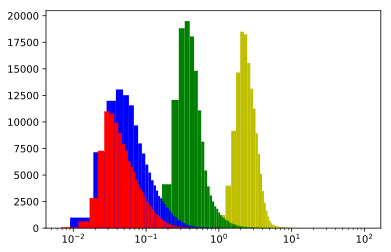

In [31]:
# plt.hist(WISEMag2mJy(myqso_W1.W1MAG,'W1'), 30 , histtype='step')
hist(WISEMag2mJy(myqso_W4.W4MAG,'W4'), 'knuth', color='y')
hist(WISEMag2mJy(myqso_W3.W3MAG,'W3'), 'knuth', color='g')
hist(WISEMag2mJy(myqso_W2.W2MAG,'W2'), 'knuth', color='b')
hist(WISEMag2mJy(myqso_W1.W1MAG,'W1'), 'knuth', color='r')
plt.xscale('log')

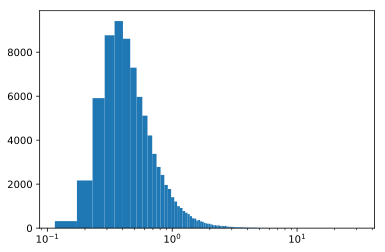

In [509]:
_ = hist(WISEMag2mJy(myqso_W3[myqso_W3.W3SNR>=2].W3MAG,'W3'), 'knuth')
plt.xscale('log')

In [275]:
s = qso.cat[0].KFLUX/qso.cat[0].KFLUX_ERR

In [276]:
len(s[s>2])*1./len(s)

0.1992753502418277

In [373]:
from utils import WISEMag2mJy

In [545]:
my_km = KM(fluxes_W4.tolist(),detected_W4.tolist())

(0.6, 100)

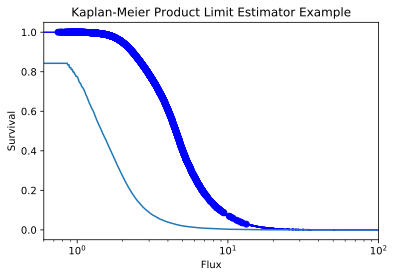

In [547]:
my_km.plot("blue", "Flux", "Kaplan-Meier Product Limit Estimator Example")
plt.plot(kmf_W4.timeline, 1.-kmf_W4.cumulative_density_, label='W4')
plt.xscale('log')
# plt.gca()
plt.xlim(0.6,100)

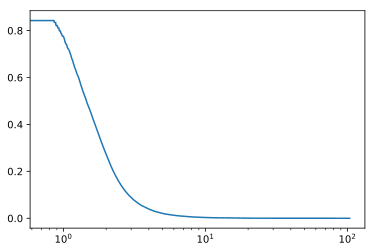

In [543]:
plt.plot(kmf_W4.timeline, 1.-kmf_W4.cumulative_density_, label='W4')
plt.xscale('log')

In [568]:
np.savetxt('/Users/fbianchini/Research/StacktSZ/fluxes_KM_test.dat', np.c_[fluxes_W4, detected_W4], fmt='%.4f %d', header='Flux [mJy]   Detected?')

NameError: name 'kmf_W4' is not defined

In [80]:
a = np.loadtxt('/Users/fbianchini/Research/StacktSZ/SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_zbin_1.0_5.0.dat')

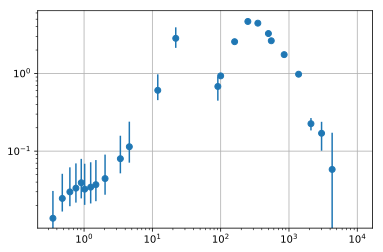

In [83]:
plt.errorbar(a[:,0], a[:,1], yerr=(a[:,2], a[:,3]) , fmt='o')
# plt.plot(a[13:18,0], a[13:18,1],'o')

plt.xscale('log')
plt.grid()
plt.yscale('log')


In [32]:
(1.-kmf_W1.cumulative_density_).max()

KM_estimate    0.999988
dtype: float64

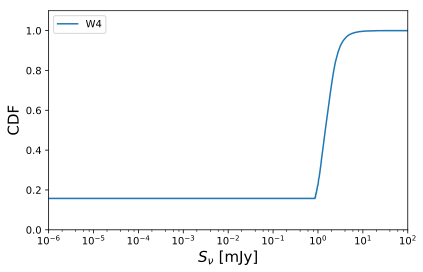

In [43]:
plt.plot(kmf_W4.timeline, kmf_W4.cumulative_density_, label='W4',)
# plt.plot(kmf_W3.timeline, kmf_W3.cumulative_density_, '--', label='W3')
# plt.plot(kmf_W2.timeline, kmf_W2.cumulative_density_, '-.', label='W2')
# plt.plot(kmf_W1.timeline, kmf_W1.cumulative_density_, ':',  label='W1')
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]', size=15)
plt.ylabel(r'CDF', size=15)
plt.xlim(1e-6,1e2)
plt.ylim(0,1.1)
plt.xscale('log')
# plt.title(r'$1<z<5$')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/StacktSZ/WISE_KaplanMeier_test_1z5_inverse.pdf')

## Analysis in z-bins

In [103]:
qso_cat_bins = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(1.0,2.15), (2.15,2.5), (2.5,5)])

	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5


In [100]:
anal_bins = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE/', zbins=[(1.0,2.15), (2.15,2.5), (2.5,5.0)], extras_names=extras_names, lambdas=[100,160,250,350,500])


# $1 < z < 2.15$

In [48]:
planck_bin1 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,2], giulio_fluxes[:-1,7]]
planck_corr_bin1 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,2], giulio_fluxes_corr[:,7]]
PLANCK_bin1 = planck_bin1.copy()
PLANCK_bin1[6:,1] -= planck_corr_bin1[:,1]
PLANCK_bin1[6:,2] = np.sqrt(PLANCK_bin1[6:,2]**2 + planck_corr_bin1[:,2]**2)
akari_bin1 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,2], giulio_fluxes[-1,7]]


In [10]:
akari_bin1

array([[ 90.9091  ,   2.25748 ,   0.394262]])

W1 22868
W2 22868
W3 22868
W4 22868
W1 23475
W2 23475
W3 23475
W4 23475
W1 23391
W2 23391
W3 23391
W4 23391
uk 11567
uk 11513
uk 11515
uk 11576
uk 26041
uk 25873
uk 25911
uk 26139
uk 28390
uk 28284
uk 28183
uk 28317
sdss u 62955
sdss g 62955
sdss r 62955
sdss i 62955
sdss z 62955
sdss u 87644
sdss g 87644
sdss r 87644
sdss i 87644
sdss z 87644
sdss u 92042
sdss g 92042
sdss r 92042
sdss i 92042
sdss z 92042
100 1.87154919242 0.186005307864
160 4.14312377484 0.407372106703
250 6.6651033851 0.29132782576
350 5.45388028656 0.281850533094
500 3.48982521582 0.244977610814


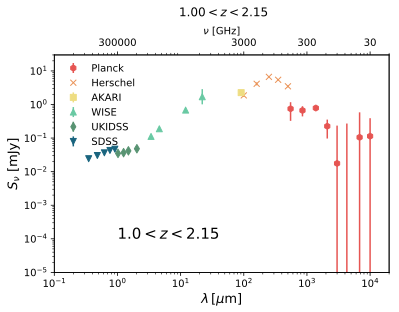

In [104]:
qso_cat_bins.PlotFromAnal(0, planck=PLANCK_bin1, akari=akari_bin1, herschel=anal_bins)
# plt.grid()
plt.text(1, 1e-4, r'$1.0 < z < 2.15$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_1_z_2.15_wPACS_wAKARI_wPlanck_CIBcorr_mean_NEW2.pdf', bboxes_inches='tight')

In [18]:
len(np.concatenate([anal_bins.cuts[500][patch][2] for patch in patches]))

2250

In [86]:
for i in xrange(3):
    print qso_cat_bins.meanw3[i] - qso_cat_bins.low3_limits[i]
    print qso_cat_bins.meanw3_noKM[i] - qso_cat_bins.low3_limits[i]

0.220095951215
0.129670117808
0.0775064485114
0.177680155846
0.0862558473615
0.179222385587


In [99]:
qso_cat_bins.hiw3_limits[0] - qso_cat_bins.meanw3_noKM[0]

0.0

In [97]:
np.mean(qso_cat_bins.detected_W3[1])

0.56241613597154483

<Container object of 3 artists>

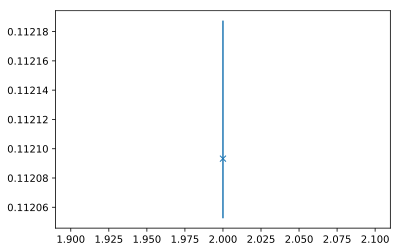

In [112]:
plt.errorbar(2, qso_cat_bins.meanw1_noKM[0], yerr=np.asarray(qso_cat_bins.errw1_limits[0]).T, fmt='x')
# plt.errorbar(3, qso_cat_bins.meanw1[1], yerr=np.asarray(qso_cat_bins.errw1_limits[1]).T, fmt='x')
# plt.errorbar(4, qso_cat_bins.meanw1[2], yerr=np.asarray(qso_cat_bins.errw1_limits[2]).T, fmt='x')
# plt.errorbar(3, qso_cat_bins.meanw2[1], yerr=np.asarray(qso_cat_bins.errw2_limits[1]).T, fmt='x')
# plt.errorbar(12, qso_cat_bins.meanw3[0], yerr=np.asarray(qso_cat_bins.errw3_limits[0]).T, fmt='x')
# plt.errorbar(22, qso_cat_bins.meanw4[0], yerr=np.asarray(qso_cat_bins.errw4_limits[0]).T, fmt='x')
# plt.errorbar(0, 1, yerr=np.asarray([[1,7]]).T, fmt='x')

In [104]:
qso_cat_bins.meanw1[0], qso_cat_bins.meanw1_noKM[0], qso_cat_bins.hiw1_limits[0] 

(0.11199892385347598, 0.11209322495238455, 0.11209322495238455)

In [47]:
qso_cat_bins.errw4_limits[0]

[(1.0643527867731812, 0.8004466747330885)]

In [ ]:
qso_cat.e

In [105]:
qso_cat_bins.WriteToFileFromAnal(0, herschel=anal_bins, planck=PLANCK_bin1, akari=akari_bin1, filename='SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_0_NEW')

100 1.86874564534
160 4.12138706422
250 5.93607990816
350 5.3602440034
500 3.70036666451


In [ ]:
qso_cat_bins.errw1_mean[0]/2.

# $2.15 < z < 2.5$

In [106]:
planck_bin2 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,3], giulio_fluxes[:-1,8]]
planck_corr_bin2 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,3], giulio_fluxes_corr[:,8]]
PLANCK_bin2 = planck_bin2.copy()
PLANCK_bin2[6:,1] -= planck_corr_bin2[:,1]
PLANCK_bin2[6:,2] = np.sqrt(PLANCK_bin2[6:,2]**2 + planck_corr_bin2[:,2]**2)
akari_bin2 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,3], giulio_fluxes[-1,8]]


100 0.447148275073 0.185299004011
160 1.83461819879 0.376834412805
250 3.94391848067 0.242060675457
350 3.95901696677 0.268924271864
500 2.66065251985 0.278467037618


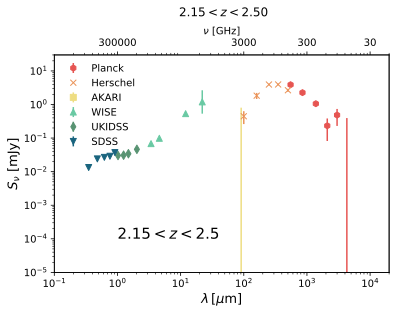

In [107]:
qso_cat_bins.PlotFromAnal(1, planck=PLANCK_bin2, akari=akari_bin2, herschel=anal_bins)
# plt.grid()
plt.text(1, 1e-4, r'$2.15 < z < 2.5$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_2.15_z_2.5_wPACS_wAKARI_wPlanck_CIBcorr_mean_NEW2.pdf', bboxes_inches='tight')

In [35]:
akari_bin2

array([[ 90.9091  ,  -0.642106,   1.44793 ]])

In [108]:
qso_cat_bins.WriteToFileFromAnal(1, herschel=anal_bins, planck=PLANCK_bin2, akari=akari_bin2, filename='SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_1_NEW')

100 0.442754837574
160 1.82394692128
250 3.93319211728
350 3.95271610858
500 2.6365577621


# $2.5 < z < 5$


In [36]:
planck_bin3 = np.c_[giulio_fluxes[:-1,0], giulio_fluxes[:-1,4], giulio_fluxes[:-1,9]]
planck_corr_bin3 = np.c_[giulio_fluxes_corr[:,0], giulio_fluxes_corr[:,4], giulio_fluxes_corr[:,9]]
PLANCK_bin3 = planck_bin3.copy()
PLANCK_bin3[6:,1] -= planck_corr_bin3[:,1]
PLANCK_bin3[6:,2] = np.sqrt(PLANCK_bin3[6:,2]**2 + planck_corr_bin3[:,2]**2)
akari_bin3 = np.c_[giulio_fluxes[-1,0], giulio_fluxes[-1,4], giulio_fluxes[-1,9]]


100 0.46599720001 0.194679984261
160 1.71915406496 0.378245177897
250 3.71784529158 0.24882978341
350 3.91491348457 0.263511741873
500 3.42625216963 0.246693862945


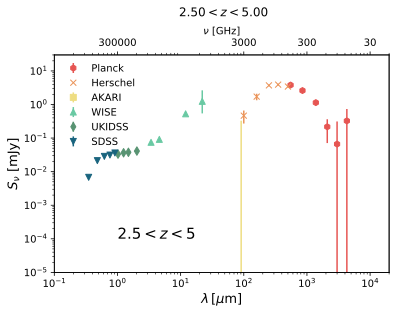

In [109]:
qso_cat_bins.PlotFromAnal(2, planck=PLANCK_bin3, akari=akari_bin3, herschel=anal_bins)
# plt.grid()
plt.text(1, 1e-4, r'$2.5 < z < 5$', fontsize=15)
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_2.5_z_5_wPACS_wAKARI_wPlanck_CIBcorr_mean_NEW2.pdf', bboxes_inches='tight')

(1e-05, 30)

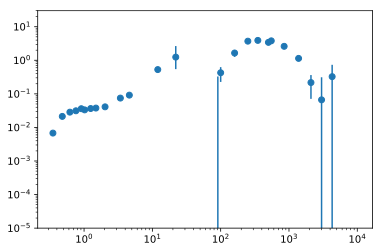

In [112]:
a = np.loadtxt('SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_NEW_zbin_2.5_5.dat')
plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='o')
plt.xscale('log');
plt.yscale('log',nonposy='clip');
plt.ylim([1e-5,30])

In [110]:
qso_cat_bins.WriteToFileFromAnal(2, herschel=anal_bins, planck=PLANCK_bin3, akari=akari_bin3, filename='SDSS_QSOs_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_NEW')

100 0.425442044962
160 1.64694254049
250 3.71051944888
350 3.91296394313
500 3.41947692274


In [133]:
a[:,1]

array([ 1.3894   ,  0.45988  ,  0.091091 ,  0.074842 ,  0.041073 ,
        0.037747 ,  0.036548 ,  0.033339 ,  0.036121 ,  0.031315 ,
        0.028511 ,  0.021323 ,  0.0067841,  0.42544  ,  1.6469   ,
        3.7105   ,  3.913    ,  3.4195   , -0.045279 , -0.34671  ,
       -0.81639  ,  0.3257   ,  0.06638  ,  0.21712  ,  1.1396   ,
        2.6069   ,  3.7994   , -5.0619   ])

In [123]:
planck_bin2

array([[  1.00000000e+04,  -6.48910000e-01,   3.23419000e-01],
       [  6.81818000e+03,  -1.27313000e+00,   5.60008000e-01],
       [  4.28571000e+03,  -2.96882000e-02,   4.24614000e-01],
       [  3.00000000e+03,   4.85142000e-01,   2.54770000e-01],
       [  2.09790000e+03,   2.33170000e-01,   1.51233000e-01],
       [  1.38249000e+03,   1.05811000e+00,   1.31350000e-01],
       [  8.49858000e+02,   4.98472000e+00,   2.45813000e-01],
       [  5.50459000e+02,   1.16611000e+01,   4.18827000e-01],
       [  3.50058000e+02,   1.07795000e+01,   5.66339000e-01]])

## x Roberto Gilli

In [79]:
qso_cat_all = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=False, z_DR12='Z_PIPE'), [(0.,10.)])

	...z-bin : 0.0 < z < 10.0


In [78]:
len(qso_cat_all.cat[0])

369004

In [81]:
369004./len(qso_cat_all.cat[0])

0.9553625289647762

In [76]:
np.savetxt('SDSS_QSO_DR7_DR12_woFIRST_cat.dat', 
           np.c_[qso_cat_all.cat[0].SDSS_NAME, qso_cat_all.cat[0].RA, qso_cat_all.cat[0].DEC, qso_cat_all.cat[0].Z],
           header='QSO SDSS-DR7 + DR-12 \n SDSS_NAME, RA, DEC, Z',
          fmt='%s %f %f %f')

In [25]:
qso_cat_bins.meanw4[0]

2.079267369587346

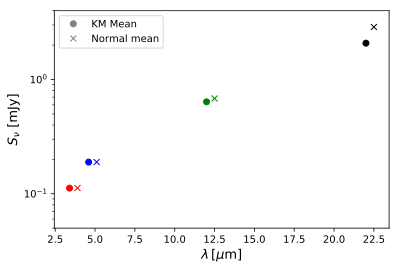

In [43]:
# plt.errorbar([3.4],  qso_cat_bins.meanw1[0], yerr=qso_cat_bins.errw1_mean[0], color='r',)
# plt.errorbar([4.6], qso_cat_bins.meanw2[0], yerr=qso_cat_bins.errw2_mean[0], color='b', )
# plt.errorbar([12],   qso_cat_bins.meanw3[0], yerr=qso_cat_bins.errw3_mean[0], color='g', )
# plt.errorbar([22],   qso_cat_bins.meanw4[0], yerr=qso_cat_bins.errw4_mean[0], color='k', )


plt.errorbar(3.4,  qso_cat_bins.meanw1[0], yerr=qso_cat_bins.errw1_mean[0], color='r', fmt='o')
plt.errorbar(4.6, qso_cat_bins.meanw2[0], yerr=qso_cat_bins.errw2_mean[0], color='b', fmt='o')
plt.errorbar(12 ,   qso_cat_bins.meanw3[0], yerr=qso_cat_bins.errw3_mean[0], color='g', fmt='o')
plt.errorbar(22 ,   qso_cat_bins.meanw4[0], yerr=qso_cat_bins.errw4_mean[0], color='k', fmt='o')

plt.errorbar(3.4+.5,  qso_cat_bins.meanw1_noKM[0], yerr=np.std(qso_cat_bins.w1mag[0])/np.sqrt(len(qso_cat_bins.w1mag[0])), color='r', fmt='x')
plt.errorbar(4.6+.5, qso_cat_bins.meanw2_noKM[0], yerr=np.std(qso_cat_bins.w2mag[0])/np.sqrt(len(qso_cat_bins.w2mag[0])), color='b', fmt='x')
plt.errorbar(12+.5 ,   qso_cat_bins.meanw3_noKM[0], yerr=np.std(qso_cat_bins.w3mag[0])/np.sqrt(len(qso_cat_bins.w3mag[0])), color='g', fmt='x')
plt.errorbar(22+.5 ,   qso_cat_bins.meanw4_noKM[0], yerr=np.std(qso_cat_bins.w4mag[0])/np.sqrt(len(qso_cat_bins.w4mag[0])), color='k', fmt='x')

plt.plot(10, 100, 'o', color='grey', label='KM Mean')
plt.plot(10, 100, 'x', color='grey', label='Normal mean')

plt.ylim(5e-2,4)

plt.legend()
plt.yscale('log')
# plt.legend()
plt.xlabel(r'$\lambda\,[\mu$m]', size=13)
plt.ylabel(r'$S_{\nu}$ [mJy]', size=13)
plt.savefig('/Users/fbianchini/Research/StacktSZ/WISE_KM_mean_vs_Normal_mean.pdf', bboxes_inches='tight')

In [8]:
a = qso_cat_bins.cat[0].YFLUX.dropna()

In [13]:
qso_cat_bins.GetFluxesCats('all')

utils.py:47: RuntimeWarning: overflow encountered in double_scalars
  return 309.540 * 10**(-mags/2.5) * 1e3
utils.py:49: RuntimeWarning: overflow encountered in double_scalars
  return 171.787 * 10**(-mags/2.5) * 1e3
utils.py:51: RuntimeWarning: overflow encountered in double_scalars
  return 31.674 * 10**(-mags/2.5) * 1e3
utils.py:53: RuntimeWarning: overflow encountered in double_scalars
  return 8.363 * 10**(-mags/2.5) * 1e3
/Users/fbianchini/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, I

W1 22868
W2 22868
W3 22868
W4 22868
W1 23475
W2 23475
W3 23475
W4 23475
W1 23391
W2 23391
W3 23391
W4 23391


utils.py:62: RuntimeWarning: overflow encountered in double_scalars
  return 1024 * 10**(-mags/2.5) * 1e3
utils.py:64: RuntimeWarning: overflow encountered in double_scalars
  return 666.7 * 10**(-mags/2.5) * 1e3
utils.py:60: RuntimeWarning: overflow encountered in double_scalars
  return 1594 * 10**(-mags/2.5) * 1e3


uk 11567
uk 11513
uk 11515
uk 11576
uk 26041
uk 25873
uk 25911
uk 26139
uk 28390
uk 28284
uk 28183
uk 28317
sdss u 62955
sdss g 62955
sdss r 62955
sdss i 62955
sdss z 62955
sdss u 87644
sdss g 87644
sdss r 87644
sdss i 87644
sdss z 87644
sdss u 92042
sdss g 92042
sdss r 92042
sdss i 92042
sdss z 92042


In [25]:
a = (qso_cat_bins.gflux[0]/qso_cat_bins.errgflux[0])

(array([  8.46300000e+03,   1.81500000e+03,   6.67000000e+02,
          3.16000000e+02,   1.35000000e+02,   6.50000000e+01,
          3.10000000e+01,   1.10000000e+01,   8.00000000e+00,
          2.00000000e+00]),
 array([  1.72273575e-03,   1.11100475e+01,   2.22183723e+01,
          3.33266971e+01,   4.44350219e+01,   5.55433466e+01,
          6.66516714e+01,   7.77599962e+01,   8.88683210e+01,
          9.99766458e+01,   1.11084971e+02]),
 <a list of 10 Patch objects>)

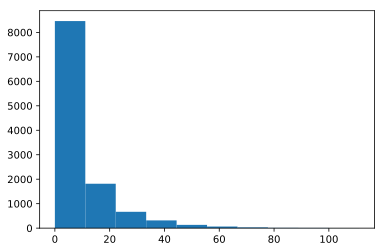

In [38]:
plt.hist(qso_cat_bins.jfluxUKIDSS[0]/qso_cat_bins.errjfluxUKIDSS[0])

In [44]:
a = qso_cat_bins.yfluxUKIDSS[0]/qso_cat_bins.erryfluxUKIDSS[0]

In [45]:
1.*a[a>2].size/a.size

0.936457162617792

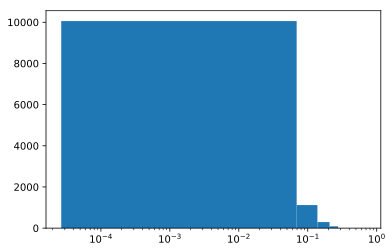

In [48]:
plt.hist(qso_cat_bins.yfluxUKIDSS[0])
plt.xscale('log')

In [55]:
for i, zbin in enumerate(qso_cat_bins.zbins):
    print 1-(1.*qso_cat_bins.detected_W1[i][qso_cat_bins.detected_W1[i]==1].size/qso_cat_bins.detected_W1[i].size)
    print 1-(1.*qso_cat_bins.detected_W2[i][qso_cat_bins.detected_W2[i]==1].size/qso_cat_bins.detected_W2[i].size)
    print 1-(1.*qso_cat_bins.detected_W3[i][qso_cat_bins.detected_W3[i]==1].size/qso_cat_bins.detected_W3[i].size)
    print 1-(1.*qso_cat_bins.detected_W4[i][qso_cat_bins.detected_W4[i]==1].size/qso_cat_bins.detected_W4[i].size)
    print ""

0.000524739270175
0.00732448564619
0.324070227606
0.702429105538

0.00117143404826
0.0318630061128
0.437583864028
0.814167962344

0.000919137293461
0.0526687044439
0.442382916872
0.815467156873

